# Why this kernel?
Why should you read through this kernel? The goal is to have a visual guide on which strategy leads to the win:

- the data will be read and **memory footprint will be reduced**;
- **missing data** will be checked;
- **aggregations of the data over teams are performed**;
- a baseline model **on team level** will be trained:
   - Gradient boosting model as implemented in **LightGBM** is used;
   - **Mean absolute error (MAE) is used as the loss function** in the training (consistently with the final evaluation metric). **FAIR loss**  was also tried and seems to lead similar results
   - Training is performed with **early stopping based on MAE metric**.
 - The training is implemented in a cross validation (CV) loop and **out-of-fold (OOF) predictions are stored** for future use in stacking.
 - **Test predictions** are obtained as an **average over predictions from models trained on k-1 fold subsets**.
- Predictions are **clipped to `[0,1]` range**

In [1]:
# The number of MATCHES to use in training. Whole training dataset is used anyway. Use it to have fast turn-around. Set to 50k for all entries
max_matches_trn=5000
# The number of entries from test to read in. Use it to have fast turn-around. Set to None for all entries
max_events_tst=1000
# Number on CV folds
n_cv=3

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

import gc
gc.enable()

from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
# print(os.listdir("../input"))

Define a function to reduce memory foorprint

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Read in the data

In [6]:
df_trn_t = pd.read_csv('/home/mlisovyi/tmp/train_V2_5k.csv.gz', nrows=None)
df_trn_t = reduce_mem_usage(df_trn_t)

# df_tst = pd.read_csv('../input/pubg-finish-placement-prediction/test_V2.csv',  nrows=max_events_tst)
# df_tst = reduce_mem_usage(df_tst)

Memory usage of dataframe is 130.63 MB
Memory usage after optimization is: 71.81 MB
Decreased by 45.0%


In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
# for c in ['matchType', 'matchId', 'groupId']:
#     df_tst[c] = LabelEncoder().fit_transform(df_tst[c])

In [9]:
df_trn = df_trn_t.query('matchId < @max_matches_trn')

In [10]:
df_val = df_trn.query('matchId >= 4000')
df_trn = df_trn.query('matchId < 4000')

In [11]:
print('Number of training entries after selecting a subset of matches: {}'.format(df_trn.shape[0]))

Number of training entries after selecting a subset of matches: 371635


In [12]:
# we will NOT use in training
features_not2use = ['Id', 'groupId', 'matchId', 'numGroups']

## How do the data look like?

In [13]:
df_trn.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,1eaf90ac73de72,843520,3143,1,0,68.00,0,0,0,47,...,0,0.0,0,0.000000,0,0,161.7500,2,0,0.775391
1,92022479b92ce7,374293,1381,0,3,254.25,0,0,12,13,...,0,2368.0,0,15.289062,0,0,1787.0000,3,0,0.821289
2,e2d4735f01b693,1444280,387,0,1,440.00,4,0,1,34,...,0,0.0,0,0.000000,0,0,353.5000,2,0,0.222168
3,5b0bb2ecf3c824,1092281,481,0,0,0.00,0,0,0,86,...,0,0.0,0,0.000000,0,0,128.7500,1,1471,0.021698
5,8b3cdbefd1f408,1665502,3403,0,0,0.00,0,0,0,91,...,0,0.0,0,0.000000,0,0,27.0625,1,0,0.000000


- The training dataset has 4.3M entries, which is not small and aloows for advanced models like GBM and NN to dominate.
- The test dataset is only 1.9M entries
- There are 25 features (+ the target in the train dataset)

# Feature engineering: group by teams

In [16]:
def fe(df_):
    for s_gb, s_name in [('groupId', 'groupSize'),
                         ('matchId', 'numPlayers')
                        ]:
        series = df_.groupby(s_gb).size().to_frame()
        series.columns = [s_name]
        df_ = df_.merge(series, left_on=s_gb, right_index=True, how='left')
    
    df_aggs = df_.groupby('matchId').agg({'killPlace':['max'],
                               #'groupId': ['min']
                              })
    df_aggs.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_aggs.columns])
    df_ = df_.merge(df_aggs, left_on='matchId', right_index=True, how='left')
    
    feats_add = [('rsDistance', 'rideDistance', 'swimDistance'),
                 ('totalDistance', 'fe_rsDistance_ADD', 'walkDistance'),
                 ('totalPoints', 'killPoints', 'winPoints'),
                 #('', '', '')
                ]
    feats_sub = []
    #feats_sub = [('groupId_DIFF', 'groupId', 'groupId_MIN')
    #            ]
    feats_div = [
                 ('headshotFraction', 'headshotKills', 'kills'),
                 ('weaponsPerMeter', 'weaponsAcquired', 'fe_totalDistance_ADD'),
                 ('kill2win', 'killPoints', 'winPoints'),
                 ('damage2kills', 'damageDealt', 'kills'),
                 ('killPlace_maxPlace' , 'killPlace', 'maxPlace'),
                ('killPlace_maxKillPlace' , 'killPlace', 'killPlace_MAX'),
                ('killPlace_numPlayers' , 'killPlace', 'numPlayers'),
                ('totalDistancePerTime','fe_totalDistance_ADD','matchDuration'),
                ('walkDistancePerTime','walkDistance','matchDuration'),
                ('matchDuration_numPlayers','matchDuration','numPlayers')
    ]

    for f_new, f1, f2 in feats_add:
        df_['fe_' + f_new + '_ADD'] = df_[f1] + df_[f2]
    for f_new, f1, f2 in feats_sub:
        df_['fe_' + f_new + '_SUB'] = df_[f1] - df_[f2]
    for f_new, f1, f2 in feats_div:
        df_['fe_' + f_new + '_DIV'] = df_[f1] / df_[f2]
        
    return df_
        
df_trn = fe(df_trn)
df_val = fe(df_val)
# df_tst = fe(df_tst)

In [17]:
df_val.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,fe_headshotFraction_DIV,fe_weaponsPerMeter_DIV,fe_kill2win_DIV,fe_damage2kills_DIV,fe_killPlace_maxPlace_DIV,fe_killPlace_maxKillPlace_DIV,fe_killPlace_numPlayers_DIV,fe_totalDistancePerTime_DIV,fe_walkDistancePerTime_DIV,fe_matchDuration_numPlayers_DIV
4,c5d63a04ebad0e,172259,4936,0,2,279.00,4,0,1,10,...,0.0,0.002018,NaN,93.000000,0.344828,0.102041,0.102041,0.519382,0.519382,19.479592
6,03cab96432e075,1724420,4447,0,3,164.75,0,0,9,54,...,NaN,0.000886,NaN,inf,1.148936,0.580645,0.580645,3.625067,0.797001,20.075269
26,4caa8ebb6b2d62,196860,4032,1,0,85.25,0,0,0,68,...,NaN,0.005947,NaN,inf,1.416667,0.723404,0.723404,0.119747,0.119747,14.936170
29,b6ab91116d04b7,1035113,4710,0,2,100.00,0,0,0,23,...,0.0,0.000598,0.808612,100.000000,0.234694,0.234694,0.234694,2.421434,2.383780,14.091837
32,86592e2adf8cbe,1898243,4717,0,0,0.00,0,0,1,79,...,NaN,0.006989,NaN,NaN,1.645833,0.849462,0.849462,0.065354,0.065354,23.548387


In [18]:
agg_team = {c: ['mean', 'min', 'max', 'sum'] 
            for c in [c 
                      for c in df_trn.columns 
                      if c not in features_not2use 
                      and c != 'winPlacePerc']
           }
rnk_match = ['fe_killPlace_numPlayers_DIV_MAX', 'fe_killPlace_maxKillPlace_DIV_MAX', 
             'walkDistance_MEAN', 'walkDistance_MAX', 'boosts_MEAN', 
             'fe_totalDistance_ADD_MEAN', 'kills_MIN', 
             'fe_walkDistancePerTime_DIV_MEAN', 'fe_walkDistancePerTime_DIV_MAX', 
             'fe_totalDistancePerTime_DIV_MAX']

agg_team['numGroups'] = ['size','median']

print(agg_team.keys())

def preprocess(df):    
    df_gb = df.groupby(['matchId','groupId']).agg(agg_team)
    df_gb.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_gb.columns])
    df_rnk = df_gb.groupby('matchId')[rnk_match].rank(pct=True)
    df_rnk.columns = [e + "_RNK" for e in df_rnk.columns]
    df_gb = df_gb.merge(df_rnk, how='left', left_index=True, right_index=True)
    df_gb.index = df_gb.index.droplevel(0)
    return df_gb

df_trn_gb = preprocess(df_trn)
df_val_gb = preprocess(df_val)
# df_tst_gb = preprocess(df_tst)

y = df_trn.groupby(['matchId','groupId'])['winPlacePerc'].median()
y.index = y.index.droplevel(0)
# target for the ranker
y_rnk = df_trn.groupby(['matchId', 'groupId'])['winPlacePerc'].median().groupby('matchId').rank().astype(np.int16)
y_rnk.index = y_rnk.index.droplevel(0)

dict_keys(['revives', 'weaponsAcquired', 'boosts', 'longestKill', 'heals', 'fe_killPlace_maxKillPlace_DIV', 'teamKills', 'numGroups', 'fe_headshotFraction_DIV', 'kills', 'fe_damage2kills_DIV', 'damageDealt', 'walkDistance', 'rideDistance', 'fe_rsDistance_ADD', 'swimDistance', 'matchDuration', 'numPlayers', 'fe_weaponsPerMeter_DIV', 'groupSize', 'rankPoints', 'vehicleDestroys', 'headshotKills', 'killPoints', 'fe_killPlace_maxPlace_DIV', 'killStreaks', 'fe_matchDuration_numPlayers_DIV', 'fe_totalDistancePerTime_DIV', 'fe_totalDistance_ADD', 'killPlace', 'fe_kill2win_DIV', 'fe_walkDistancePerTime_DIV', 'matchType', 'maxPlace', 'killPlace_MAX', 'DBNOs', 'assists', 'roadKills', 'fe_killPlace_numPlayers_DIV', 'fe_totalPoints_ADD', 'winPoints'])


# Prepare the data

In [22]:
df_trn_2 = reduce_mem_usage(df_trn.merge(df_trn_gb, how='left', left_on='groupId', right_index=True))
#needed to organise training data for grouping
#df_trn_2.sort_values(by=['matchId','groupId'], inplace=True)
# target for the players
y_player = df_trn_2['winPlacePerc']
df_trn_2.drop('winPlacePerc', axis=1, inplace=True)

# df_tst_2 = reduce_mem_usage(df_tst.merge(df_tst_gb, how='left', left_on='groupId', right_index=True))
df_val_2 = reduce_mem_usage(df_val.merge(df_val_gb, how='left', left_on='groupId', right_index=True))

df_trn_2.drop('Id', axis=1, inplace=True)
# df_tst_2.drop('Id', axis=1, inplace=True)
df_val_2.drop('Id', axis=1, inplace=True)

#del df_trn, df_trn_gb
gc.collect()

Memory usage of dataframe is 363.40 MB
Memory usage after optimization is: 214.90 MB
Decreased by 40.9%
Memory usage of dataframe is 129.78 MB
Memory usage after optimization is: 92.21 MB
Decreased by 28.9%


28

In [20]:
g_game_trn = df_trn_2['matchId']
g_team_trn  = df_trn_2['groupId']

# Train and evaluate a model
Start by defining handy helper functions...

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin
import lightgbm as lgb


def learning_rate_decay_power(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    base_learning_rate = 0.2
    min_lr = 5.0e-2
    lr = base_learning_rate  * np.power(.998, current_iter)
    return lr if lr > min_lr else min_lr


def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    '''
    A wrapper to train a model with particular parameters
    '''
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True,
                            groups=None, y_eval=None):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    sample_weight=None
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    index_weight=None
    if 'index_weight' in metric_args:
        index_weight=metric_args['index_weight']
        del metric_args['index_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    if groups is None:
        cv = KFold(n, shuffle=True, random_state=seed) #Stratified
    else:
        cv = GroupKFold(n)
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8), groups=groups)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if 'LGBMRanker' in type(model).__name__ and groups is not None:
            G_trn, G_val = groups.iloc[trn_idx], groups.iloc[val_idx]        

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose
            if index_weight is not None:
                fit_params_["sample_weight"] = y_trn.index.map(index_weight).values
                fit_params_["eval_sample_weight"] = [None, y_val.index.map(index_weight).values]
            if 'LGBMRanker' in type(model).__name__ and groups is not None:
                fit_params_['group'] = G_trn.groupby(G_trn, sort=False).count()
                fit_params_['eval_group'] = [G_trn.groupby(G_trn, sort=False).count(),
                                             G_val.groupby(G_val, sort=False).count()]

        #display(y_trn.head())
        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # oof predictions
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin):
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            y_oof.iloc[val_idx] = clf.predict(X_val)
        # prepare weights for evaluation
        if sample_weight is not None:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        elif index_weight is not None:
            metric_args['sample_weight'] = y_val.index.map(index_weight).values
        # prepare target values
        y_true_tmp = y_val if 'LGBMRanker' not in type(model).__name__  and y_eval is None else y_eval.iloc[val_idx]
        y_pred_tmp = y_oof.iloc[val_idx] if y_eval is None else y_oof.iloc[val_idx]        
        #store evaluated metric
        scores.append(metric(y_true_tmp, y_pred_tmp, **metric_args))
        #cleanup
        del X_trn, y_trn, X_val, y_val, y_true_tmp, y_pred_tmp

    # Store performance info for this CV
    if sample_weight is not None:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    elif index_weight is not None:
        metric_args['sample_weight'] = y_oof.index.map(index_weight).values
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} Classifier: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(perf_eval['score_i']))

Now let's define the parameter and model in a scalable fashion (we can add later on further models to the list and it will work out-of-the-box). 

The format is a dictionary with keys that are user model names and items being an array (or tuple) of:

- model to be fitted;
- additional model parameters to be set;
- model fit parameters (they are passed to `model.fit()` call);
- target variable.

In [23]:
mdl_inputs = {
#         # This will be with MAE loss
#             'lgbm1_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=40, random_state=314, silent=True, metric='None', 
#                                         n_jobs=4, n_estimators=1000, learning_rate=0.05),
#                  {'objective': 'mse', 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 200, 'reg_alpha': 1},#, 'subsample': 0.75}, 
#                  {"early_stopping_rounds":20, 
#                   "eval_metric" : 'mae',
#                   'eval_names': ['train', 'early_stop'],
#                   'verbose': False, 
#                   'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
#                   'categorical_feature': 'auto'},
#                  y_player,
#                  None
#                 ),
            'lgbm2_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=40, random_state=314, silent=True, metric='None', 
                                        n_jobs=4, n_estimators=1000, learning_rate=0.05),
                 {'objective': 'mse', 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 200, 'reg_alpha': 1},#, 'subsample': 0.75}, 
                 {"early_stopping_rounds":20, 
                  "eval_metric" : 'mae',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': False, 
                  'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 y_player,
                 g_game_trn
                ),
#             'lgbm3_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=40, random_state=314, silent=True, metric='None', 
#                                         n_jobs=4, n_estimators=1000, learning_rate=0.05),
#                  {'objective': 'mse', 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 200, 'reg_alpha': 1},#, 'subsample': 0.75}, 
#                  {"early_stopping_rounds":20, 
#                   "eval_metric" : 'mae',
#                   'eval_names': ['train', 'early_stop'],
#                   'verbose': False, 
#                   'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
#                   'categorical_feature': 'auto'},
#                  y_player,
#                  g_team_trn
#                 ),
       }

Do the actual model training

In [24]:
%%time
l = [c for c in df_trn_2.columns if c not in features_not2use]

mdls = {}
results = {}
y_oofs = {}
for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    print('--------------- {} -----------'.format(name))
    mdl_, perf_eval_, y_oof_ = train_model_in_CV(mdl, df_trn_2[l],
                                                 y_, mean_absolute_error, 
                                                          metric_args={},
                                                          model_name=name, 
                                                          opt_parameters_=mdl_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=500, 
                                                          groups=g_)
    results[name] = perf_eval_
    mdls[name] = mdl_
    y_oofs[name] = y_oof_
    print_perf_clf(name, perf_eval_)

--------------- lgbm2_reg -----------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[77]	train's l1: 0.0207454	early_stop's l1: 0.0288787
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[64]	train's l1: 0.0216701	early_stop's l1: 0.0289675
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[92]	train's l1: 0.0199501	early_stop's l1: 0.0292069
Performance of the model:
Mean(Val) score inner lgbm2_reg Classifier: 0.0290+-0.0001
Min/max scores on folds: 0.0289 / 0.0292
OOF score inner lgbm2_reg Classifier: 0.0290
Scores in individual folds: [0.028878743901096654, 0.028967455787180258, 0.029206896766381274]
--------------- lgbm3_reg -----------
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[243]	train's l1: 0.0156223	early_stop's l1: 0.0277244
Training until validation scores don't improve for 20

Let's plot how predictions look like

Text(0.5,0,'Predicted winPlacePerc OOF ')

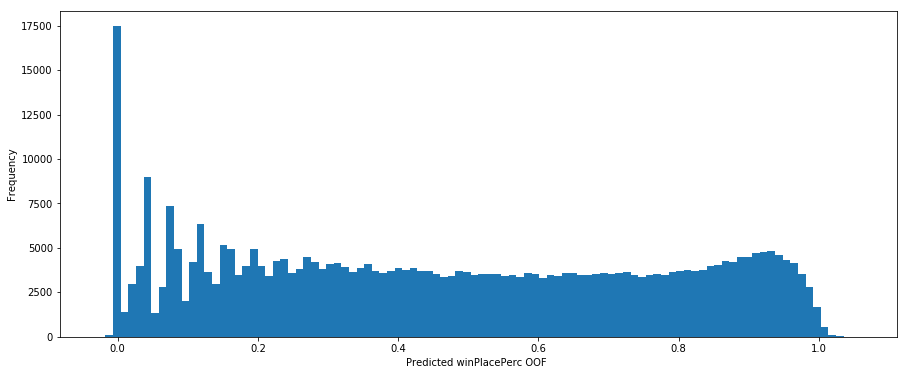

In [45]:
k = list(y_oofs.keys())[0]
_ = y_oofs[k].plot('hist', bins=100, figsize=(15,6))
plt.xlabel('Predicted winPlacePerc OOF ')

Note, that predictions are spilled outside of the `[0,1]` range, which is not meaningful for percentage value. **We will clip test predictions to be within the meaningful range.** This will improve the score slightly

## Visualise importance of features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_importances(feature_importance_df_, n_feat=30, silent=False, dump_strs=[], 
                        fout_name=None, title='Features (avg over folds)'):
    '''
    Make a plot of most important features from a tree-based model

    Parameters
    ----------
    feature_importance_df_ : pd.DataFrame
        The input dataframe. 
        Must contain columns `'feature'` and `'importance'`.
        The dataframe will be first grouped by `'feature'` and the mean `'importance'` will be calculated.
        This allows to calculate and plot importance averaged over folds, 
        when the same features appear in the dataframe as many time as there are folds in CV.
    n_feats : int [default: 20]
        The maximum number of the top features to be plotted
    silent : bool [default: False]
        Dump additionsl information, in particular the mean importances for features 
        defined by `dump_strs` and the features with zero (<1e-3) importance
    dump_strs : list of strings [default: []]
        Features containing either of these srings will be printed to the screen
    fout_name : str or None [default: None]
        The name of the file to dump the figure. 
        If `None`, no file is created (to be used in notebooks)
    '''
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index  
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    
    if not silent:
        print('The list of features with 0 importance: ')
        print(df_2_neglect.index.values.tolist())

        pd.set_option('display.max_rows', 500)
        pd.set_option('display.max_columns', 500)
        for feat_prefix in dump_strs:
            feat_names = [x for x in mean_imp.index if feat_prefix in x]
            print(mean_imp.loc[feat_names].sort_values(by='importance', ascending=False))
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(title)
    plt.tight_layout()

    if fout_name is not None:
        plt.savefig(fout_name)


In [ ]:
display_importances(pd.DataFrame({'feature': l,#df_trn_gb.columns,
                                  'importance': mdls['lgbm1_reg'][0][1].booster_.feature_importance('gain')}),
                    n_feat=20,
                    title='GAIN feature importance',
                    fout_name='feature_importance_gain.png',
                    dump_strs=[]#['_']
                   )

In [ ]:
# import shap 

In [ ]:
# explainer=shap.TreeExplainer(mdls['lgbm1_reg'][0][1])
# shap_values = explainer.shap_values(df_trn_gb[l])
# shap.summary_plot(shap_values, df_trn_gb, plot_type="bar")

In [ ]:
# x = pd.Series(np.mean(np.abs(shap_values), axis=0), index=df_trn_gb.columns)

## Prepare submission

In [27]:
%%time
for c in mdl_inputs:
    print('1')
    mdls_= mdls[c]
    y_val = np.zeros(df_val_2.shape[0])
    print('2')
    for mdl_ in mdls_:
        y_ = np.clip(mdl_[1].predict(df_val_2[l]), 0, 1)
        y_val += y_
        print('{:.4f}'.format(mean_absolute_error(df_val_2['winPlacePerc'], y_)))
    y_val /= len(mdls_)
    
    print('Average for {}: {:.4f}'.format(c, mean_absolute_error(df_val_2['winPlacePerc'], y_val)))

1
2
0.0288
0.0289
0.0290
Average for lgbm2_reg: 0.0280
1
2
0.0290
0.0290
0.0290
Average for lgbm3_reg: 0.0280
1
2
0.0288
0.0289
0.0288
Average for lgbm1_reg: 0.0280
CPU times: user 1min 31s, sys: 810 ms, total: 1min 32s
Wall time: 23.1 s


In [ ]:
%%time
y_subs= {}
for c in mdl_inputs:
    print('1')
    mdls_= mdls[c]
    y_sub = np.zeros(df_tst_2.shape[0])
    print('2')
    for mdl_ in mdls_:
        print('+')
        y_sub += np.clip(mdl_[1].predict(df_tst_2[l]), 0, 1)
    y_sub /= n_cv
    
    y_subs[c] = y_sub

In [ ]:
df_sub = pd.read_csv('../input/pubg-finish-placement-prediction/sample_submission_V2.csv', nrows=max_events_tst)

In [ ]:
pd.DataFrame.rename?

In [ ]:

for c in mdl_inputs:
    #Submission predictions
    df_sub['winPlacePerc'] = y_subs[c]
    df_sub.to_csv('sub_{}.csv'.format(c), index=False)
    
    df_sub['winPlacePerc'] = np.round(y_subs[c]*(df_tst_2['maxPlace']-1)) / (df_tst_2['maxPlace']-1)
    df_sub.to_csv('sub_{}_gapfix.csv'.format(c), index=False)
    #submission predictions ranked within each game
    y_sub_ranked = df_sub.merge(df_tst_2[['groupId', 'matchId']].drop_duplicates(), 
                           left_index=True, 
                           right_on='groupId', 
                           how='left').drop('Id',axis=1).set_index(['matchId','groupId']).groupby(['matchId']).rank(pct=True)
    df_sub['winPlacePerc'] = y_sub_ranked.values
    df_sub.to_csv('sub_{}_ranked.csv'.format(c), index=False)
    
    # OOF predictions
    oof = pd.DataFrame(index=df_trn_2.index, columns=['winPlacePerc'])
    oof['winPlacePerc'] = y_oofs[c].values
    oof.clip(0, 1, inplace=True)
    print('{} MAE OOF score = {:.4f}'.format(c, mean_absolute_error(y_player, oof['winPlacePerc'])))
    oof.to_csv('oof_{}.csv'.format(c), index=False)
    # enforce the gap between relative places
    oof['winPlacePerc'] = np.round(y_oofs[c]*(df_trn_2['maxPlace']-1)) / (df_trn_2['maxPlace']-1)
    print('{} MAE OOF score (with gap enforcement) = {:.4f}'.format(c, mean_absolute_error(y_player, oof['winPlacePerc'])))
    oof.to_csv('oof_{}_gapfix.csv'.format(c), index=False)
    # OOF predictions ranked
#     y_oof_ranked = (pd.concat([df_trn_2[['groupId', 'matchId']], y_oofs[c]], axis=1)
#                     .groupby(['matchId','groupId'])[0]
#                     .agg('mean')
#                     .groupby('matchId')
#                     .rank(pct=True)
#                     .reset_index()
#                     .rename(columns={0:'winPlacePerc'})
#                    )
#     #display(y_oof_ranked.head())
#     y_oof_ranked.columns = [c if 'winPlacePerc' not in c else c+'_Rank' for c in y_oof_ranked.columns]
#     y_oof_ranked = y_oof_ranked.merge(df_trn_2, how='left', on=['matchId','groupId'])
#     oof['winPlacePerc'] = (df_trn_2[['groupId', 'matchId']].merge(y_oof_ranked, how='left', on=['matchId','groupId'])['winPlacePerc_Rank']).values
#     print('{} ranked MAE OOF score = {:.4f}'.format(c, mean_absolute_error(y_player, oof['winPlacePerc'])))
#     oof.to_csv('oof_{}_ranked.csv'.format(c), index=False)

In [ ]:
# y_oof_ranked = (pd.concat([df_trn_2[['groupId', 'matchId']], y_oofs[c]], axis=1)
#                     .groupby(['matchId','groupId'])[0]
#                     .agg('mean')
#                     .groupby('matchId')
#                     .rank(pct=True)
#                     .reset_index()
#                     .rename(columns={0:'winPlacePerc'})
#                    )
# y_oof_ranked.columns = [c if 'winPlacePerc' not in c else c+'_Rank' for c in y_oof_ranked.columns]

In [ ]:
!ls